# Explore feature combinations from a database

We want to analyze multiwavelength data from several AGNs.  
In order to do that, we have compiled data from $18023$ sources.  
They have been retrieved from the review from **Inayoshi et al., 2020**, 
the `COSMOS` catalog  
(`VLA-COSMOS 3 GHz Large Project`; **Smolčić et al. 2017**), and from  
the Million Quasar Catalog (`Milliquas`; **Flesch, 2019**) combined with the  
cross-matching between `SDSS QUASAR DR12` catalog and `FIRST` observations.  
Additional observations were also added from the `radio` database catalog,  
compiled by NASA's `HEASARC` team.

In this way, we select sources with observations in radio frequencies.

Previously, we have selected features which can add the most information  
to the analysis. Now, we want to find ways to mixture the features to obtain  
possible correlations among our data.

---

## Python setup

First, we import the packages to be used

To get the first line working, you need  
to run the following lines:

```bash
 conda install nodejs
 pip install ipympl
 pip install --upgrade jupyterlab
 jupyter labextension install @jupyter-widgets/jupyterlab-manager
 jupyter labextension install jupyter-matplotlib
 jupyter nbextension enable --py widgetsnbextension
 ```

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# from matplotlib.ticker import FormatStrFormatter
# from matplotlib.patches import Polygon
# from astropy.wcs import WCS
from astropy import units as u
from astropy.visualization import hist
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM
# from astroquery.simbad import Simbad
# from astroquery.ned import Ned
from scipy.cluster import hierarchy as hc
from scipy.spatial import distance
from sklearn.impute import SimpleImputer
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
import getpass
import progressbar
import pandas as pd
import re
import missingno as msno
import itertools
from chainconsumer import ChainConsumer

Define the spectral index $\alpha$ from different sources  
to be used in the luminosity calculations (K-correction)

In [2]:
alpha_first = 0.5  # From FIRST data (Bornancini+2010)
alpha_RG    = 1.0  # For radio galaxies (Verkhodanov & Khabibullina, 2010)
alpha_alex  = 0.8  # Star-forming galaxies (Alexander+2003)
alpha_smol  = 0.7  # Mean value from VLA-COSMOS 3GHz sample (Smolčić et al. 2017)
alpha_butl  = 0.75  # From Butler et al., 2018

Choose one of the spectral indexes

In [3]:
alpha_used  = alpha_butl

We define the cosmological properties to calculate luminosity distances and other quantities.

In [4]:
cosmo       = FlatLambdaCDM(H0=70, Om0=0.3)

In [5]:
def lum_from_flux(flux, redshift):  # Flux in mJy
    lum_distance = cosmo.luminosity_distance(redshift).to(u.m).value  # in m
    luminosity   = 4 * np.pi * lum_distance**2 * flux * 1e-3  * 1e-26 * (1 + redshift)**(alpha_used - 1)  # in W/Hz
    return luminosity

Create class to normalize asymmetric colorscales  
(from [http://chris35wills.github.io/matplotlib_diverging_colorbar/](http://chris35wills.github.io/matplotlib_diverging_colorbar/)).

In [6]:
class MidpointNormalize(mcolors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mcolors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

For future plots, we can configure their aspect too.

In [7]:
cmap           = cm.get_cmap('inferno')
cmap_alt       = cm.get_cmap('Dark2')
dark_color     = cmap(0.4)  # RGBA color code
light_color    = cmap(0.6)  # RGBA color code
colors         = [cmap(0.15), cmap(0.30), cmap(0.45), cmap(0.60), cmap(0.75), cmap(0.90)]
colors_8       = [cmap(0.12), cmap(0.24), cmap(0.35), cmap(0.48), cmap(0.60), cmap(0.72), cmap(0.84), cmap(0.96)]
colors_8_alt   = [cmap_alt(0.12), cmap_alt(0.24), cmap_alt(0.35), cmap_alt(0.48), cmap_alt(0.6), cmap_alt(0.72),\
                  cmap_alt(0.84), cmap_alt(0.96)]
colors_5_alt   = [cmap_alt(0.1), cmap_alt(0.3), cmap_alt(0.5), cmap_alt(0.7), cmap_alt(0.9)]

In [8]:
pe1            = [mpe.Stroke(linewidth=3, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]

alp_str        = r'$\alpha$'

Define function to calculate and plot spectral indices.

In [9]:
def plot_spec_index(col_a, col_b, ax1):
    quot          = np.log10(large_catalog_df[col_a] / large_catalog_df[col_b]) / np.log10(bands_freqs[col_b] / bands_freqs[col_a])
    filter_pos    = np.array((large_catalog_df[col_a] > 0) & (large_catalog_df[col_b] > 0)) # Use only positive flux values
    filter_finite = np.isfinite(quot) & filter_pos
    
    # Randomize order of elements to plot
    indices       = np.arange(np.sum(filter_finite))
    np.random.shuffle(indices)
    
    # Calculate median value for each subsample
    med_value_q   = {}
    for key in origin_labels:
        if key not in np.unique(origin_df[filter_finite].values[indices]):
            continue
        med_value_q[key] = np.nanmedian(quot[filter_finite & (origin_df == key)])
    # med_value_q   = np.nanmedian(quot[filter_finite])
    
    # Plot the median alpha value
    for key in origin_labels:
        if key not in np.unique(origin_df[filter_finite].values[indices]):
            continue
        axis_to_data = ax1.transLimits + ax1.transData.inverted()
        data_to_axis = axis_to_data.inverted()
        
        c_1 = data_to_axis.transform((redshift_df[filter_finite].max()*0.85, med_value_q[key]))
        c_2 = axis_to_data.transform((c_1[0], c_1[1]*1.2))
        # print(c_2)
        
        sub_samp_name = origin_labels[key]
        ax1.axhline(y=med_value_q[key], ls='dashed', color='k', alpha=0.45, lw=1,\
                    label=('Median ' + origin_labels[key] + ' ' + r'$\alpha$' + ': '))
        ax1.text(c_2[0], c_2[1],\
                 f'Median {sub_samp_name:s}: {med_value_q[key]:.2f}', ha='center', va='center', color='k', alpha=0.55, size=14)
    
    # Plot the data
    scatter_out  = ax1.scatter(redshift_df[filter_finite].values[indices], quot[filter_finite].values[indices],\
                               c=origin_df[filter_finite].values[indices], alpha=0.80, marker='o',\
                               s=85, cmap='Dark2', edgecolor='k', linewidths=0.5)
    
    col_a_label  = '\mathrm{' + col_a.replace('Flux ', '') + '}'
    col_b_label  = '\mathrm{' + col_b.replace('Flux ', '') + '}'
    col_Y_label  = r'\alpha_{' + col_b_label + '}^{' + col_a_label + '}'
    
    axis_label   = f'${col_Y_label}$'
    
    ax1.set_xlabel('redshift', size=14)
    # ax1.set_ylabel('quotient', size=14)
    ax1.set_ylabel(axis_label, size=17)
    ax1.tick_params(which='both',top=True, right=True, direction='in')
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(which='major', length=8, width=1.5)
    ax1.tick_params(which='minor', length=4, width=1.5)
    
    # produce a legend with the unique colors from the scatter
    classes = [origin_labels[flag] for flag in np.unique(origin_df[filter_finite])]
    # classes = ['FIRST', 'COSMOS', 'RADIO', 'Stripe82',  'Inayoshi']
    plt.legend(handles=scatter_out.legend_elements()[0], labels=classes, markerscale=2, edgecolor='k', prop={'size': 11}, loc='best')
    
    plt.setp(ax1.spines.values(), linewidth=2.5)

Function to create scatter plots (index vs. redshift) with histograms for features.  
Points separated by origin.

In [10]:
def plot_spec_index_hist(col_a, col_b, fig):
    
    widths          = [2, 2, 1]
    heights         = [1, 2, 2]
    grid            = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights,\
                                       hspace=0.0, wspace=0.0)
    axes            = {}
    
    axes[0]         = fig.add_subplot(grid[1, 0])                                                # FIRST
    axes[1]         = fig.add_subplot(grid[1, 1], sharex=axes[0], sharey=axes[0])                # COSMOS
    axes[3]         = fig.add_subplot(grid[2, 0], sharex=axes[0], sharey=axes[0])                # Stripe82
    axes[4]         = fig.add_subplot(grid[2, 1], sharex=axes[0], sharey=axes[0])                # Inayoshi
    axes[5]         = fig.add_subplot(grid[0, 0], sharex=axes[0], yscale='log')                  # z - 
    axes[6]         = fig.add_subplot(grid[0, 1], sharex=axes[0], sharey=axes[5])                # z - 
    axes[7]         = fig.add_subplot(grid[1, 2],                 sharey=axes[0], xscale='log')  # alpha - 
    axes[8]         = fig.add_subplot(grid[2, 2], sharex=axes[7], sharey=axes[0])                # alpha - 
    axes[9]         = fig.add_subplot(grid[0, 2], xticklabels=[], yticklabels=[])                # colorbar
    
    quot          = np.log10(large_catalog_df[col_a] / large_catalog_df[col_b]) / np.log10(bands_freqs[col_b] / bands_freqs[col_a])
    filter_pos    = np.array((large_catalog_df[col_a] > 0) & (large_catalog_df[col_b] > 0)) # Use only positive flux values
    filter_finite = np.isfinite(quot) & filter_pos
    
    # Create log bins for linear-scale histograms
    min_val_z     = redshift_df[filter_finite].min()
    max_val_z     = redshift_df[filter_finite].max()
    bins_z        = np.linspace(min_val_z, max_val_z, 50)
    
    # Create linear bins for linear-scale histograms
    min_val_alpha = quot[filter_finite].min()
    max_val_alpha = quot[filter_finite].max()
    bins_alpha    = np.linspace(min_val_alpha, max_val_alpha, 50)
    
    # Create linear bins for log-scale 1.4GHz Luminosity
    min_val_lums = lum_20cm_df[filter_finite].min()
    max_val_lums = lum_20cm_df[filter_finite].max()
    
    # Randomize order of elements to plot
    indices       = np.arange(np.sum(filter_finite))
    np.random.shuffle(indices)
    
    # Calculate median value for each subsample
    med_value_q   = {}
    for key in origin_labels:
        if key not in np.unique(origin_df[filter_finite].values[indices]):
            continue
        med_value_q[key] = np.nanmedian(quot[filter_finite & (origin_df == key)])
    # med_value_q   = np.nanmedian(quot[filter_finite])
    
    # Plot the median alpha value
    # for key in origin_labels:
    #     if key not in np.unique(origin_df[filter_finite].values[indices]):
    #         continue
    #     axis_to_data = ax1.transLimits + ax1.transData.inverted()
    #     data_to_axis = axis_to_data.inverted()
    #     
    #     c_1 = data_to_axis.transform((redshift_df[filter_finite].max()*0.85, med_value_q[key]))
    #     # print(c_1)
    #     # inv = ax1.transAxes + ax1.transData.inverted()
    #     c_2 = axis_to_data.transform((c_1[0], c_1[1]*1.2))
    #     # print(c_2)
    #     
    #     sub_samp_name = origin_labels[key]
    #     ax1.axhline(y=med_value_q[key], ls='dashed', color='k', alpha=0.45, lw=1,\
    #                 label=('Median ' + origin_labels[key] + ' ' + r'$\alpha$' + ': '))
    #     ax1.text(c_2[0], c_2[1],\
    #              f'Median {sub_samp_name:s}: {med_value_q[key]:.2f}', ha='center', va='center', color='k', alpha=0.55, size=14)
    #     # ax1.text(redshift_df[filter_finite].max()*0.95, med_value_q[key]*1.2,\
    #     #          f'Median {sub_samp_name:s}: {med_value_q[key]:.2f}', ha='center', va='center', color='k', alpha=0.55, size=14)
    
    # ax1.axhline(y=med_value_q, ls='dashed', color='k', alpha=0.45, lw=1, label=('Median ' + r'$\alpha$'))
    # ax1.text(redshift_df[filter_finite].max()*0.95, med_value_q*1.2, f'median:{med_value_q:.2f}',\
    #          ha='center', va='center', color='k', alpha=0.55, size=14)
    # Plot the data
    scatter_plots = {}
    dummy_scatter = {}
    for key in origin_labels:
        # Randomize order of elements to plot
        indices_s           = np.arange(np.sum(filter_finite & (origin_df == key)))
        np.random.shuffle(indices_s)
        scatter_plots[key]  = axes[key].scatter(redshift_df[filter_finite & (origin_df == key)].values[indices_s],\
                                         quot[filter_finite & (origin_df == key)].values[indices_s],\
                                         c=lum_20cm_df[filter_finite & (origin_df == key)].values[indices_s], alpha=0.80,\
                                         marker='o', s=85, cmap='inferno', edgecolor=colors_5_alt[key], linewidths=1.0,\
                                               norm=mcolors.LogNorm(vmin=min_val_lums, vmax=max_val_lums))
        dummy_scatter[key]  = axes[key].scatter([], [], c=[colors_5_alt[key]], alpha=0.80,\
                                         marker='o', s=85, edgecolor='k', linewidths=1.5, label=origin_labels[key])
    
    col_a_label  = '\mathrm{' + col_a.replace('Flux ', '') + '}'
    col_b_label  = '\mathrm{' + col_b.replace('Flux ', '') + '}'
    col_Y_label  = r'\alpha_{' + col_b_label + '}^{' + col_a_label + '}'
    
    axis_label   = f'${col_Y_label}$'
    
    for key in origin_labels:
        axes[key].tick_params(which='both',top=True, right=True, direction='in')
        axes[key].tick_params(axis='both', which='major', labelsize=14)
        axes[key].tick_params(which='major', length=8, width=1.5)
        axes[key].tick_params(which='minor', length=4, width=1.5)
    
    for value in [5, 6, 7, 8]:
        axes[value].tick_params(which='both', top=True, right=True, direction='in')
        axes[value].tick_params(axis='both', which='major', labelsize=14)
        axes[value].tick_params(which='major', length=8, width=1.5)
        axes[value].tick_params(which='minor', length=4, width=1.5)
    
    axes[0].set_ylabel(axis_label, size=17)
    axes[3].set_ylabel(axis_label, size=17)
    axes[3].set_xlabel('redshift', size=14)
    axes[4].set_xlabel('redshift', size=14)
    
    axes[5].set_ylabel('Number', size=14)
    axes[8].set_xlabel('Number', size=14)
    
    axes[0].yaxis.set_tick_params(which='major', labelleft=True)
    axes[0].xaxis.set_tick_params(which='major', labelbottom=False)
    axes[1].yaxis.set_tick_params(which='major', labelleft=False)
    axes[1].xaxis.set_tick_params(which='major', labelbottom=False)
    axes[3].yaxis.set_tick_params(which='major', labelleft=True)
    axes[3].xaxis.set_tick_params(which='major', labelbottom=True)
    axes[4].yaxis.set_tick_params(which='major', labelleft=False)
    axes[4].xaxis.set_tick_params(which='major', labelbottom=True)
    axes[5].yaxis.set_tick_params(which='major', labelleft=True)
    axes[5].xaxis.set_tick_params(which='major', labelbottom=False)
    axes[6].yaxis.set_tick_params(which='both',  labelleft=False)
    axes[6].xaxis.set_tick_params(which='major', labelbottom=False)
    axes[7].yaxis.set_tick_params(which='major', labelleft=False)
    axes[7].xaxis.set_tick_params(which='major', labelbottom=False, labeltop=False)
    axes[8].yaxis.set_tick_params(which='major', labelleft=False)
    axes[8].xaxis.set_tick_params(which='major', labelbottom=True)
    
    axes[9].yaxis.set_tick_params(which='major', labelleft=False, left=False)
    axes[9].xaxis.set_tick_params(which='major', labelbottom=False, bottom=False)
    
    # Create colorbar and plot it
    cbaxes         = inset_axes(axes[9], width="93%", height="20%", loc=10, borderpad=0) 
    clb            = plt.colorbar(scatter_plots[0], cax=cbaxes, orientation='horizontal')
    clb.ax.tick_params(labelsize=11) 
    clb.ax.set_title('$\mathrm{L}_{1.4-1.7 \mathrm{GHz}} [\mathrm{W/Hz}]$', size=14)
    
    
    # Plot histograms
    axes[5].hist(redshift_df[filter_finite & (origin_df == 0)], bins=bins_z, histtype='stepfilled', alpha=0.8,\
                 color=colors_5_alt[0], ec='k', lw=1.5)
    axes[5].hist(redshift_df[filter_finite & (origin_df == 3)], bins=bins_z, histtype='stepfilled', alpha=0.8,\
                 color=colors_5_alt[3], ec='k', lw=1.5)
    
    axes[6].hist(redshift_df[filter_finite & (origin_df == 1)], bins=bins_z, histtype='stepfilled', alpha=0.8,\
                 color=colors_5_alt[1], ec='k', lw=1.5)
    axes[6].hist(redshift_df[filter_finite & (origin_df == 4)], bins=bins_z, histtype='stepfilled', alpha=0.8,\
                 color=colors_5_alt[4], ec='k', lw=1.5)
    
    axes[7].hist(quot[filter_finite & (origin_df == 0)], bins=bins_alpha, histtype='stepfilled', orientation='horizontal',\
                 alpha=0.8, color=colors_5_alt[0], ec='k', lw=1.5)
    axes[7].hist(quot[filter_finite & (origin_df == 1)], bins=bins_alpha, histtype='stepfilled', orientation='horizontal',\
                 alpha=0.8, color=colors_5_alt[1], ec='k', lw=1.5)
    
    axes[8].hist(quot[filter_finite & (origin_df == 3)], bins=bins_alpha, histtype='stepfilled', orientation='horizontal',\
                 alpha=0.8, color=colors_5_alt[3], ec='k', lw=1.5)
    axes[8].hist(quot[filter_finite & (origin_df == 4)], bins=bins_alpha, histtype='stepfilled', orientation='horizontal',\
                 alpha=0.8, color=colors_5_alt[4], ec='k', lw=1.5)
    
    for key in origin_labels:
        axes[key].legend(markerscale=1.5, edgecolor='k', prop={'size': 11}, loc=4)
    
    for key in origin_labels:
        plt.setp(axes[key].spines.values(), linewidth=2.5)
    for value in [5, 6, 7, 8, 9]:
        plt.setp(axes[value].spines.values(), linewidth=2.5)

---

## Reading data

In [11]:
machine  = getpass.getuser()
# cat_path = '/home/' + machine + '/Documentos/Data/'
cat_path = ''  # relative path to the same directory

We import our data using the `pandas` package.  

We separate our data in luminosities and redshift values (column name `z_value`).

It is important to keep in mind that columns with luminosity values start their names with `Flux...`  
and they are in `W / Hz`.  

Uncertainties have not been included up to this point. They are included (as flux uncertainties in the file `large_cat_simbad_inayoshi_ned.h5`).

In [12]:
file_name        = 'large_cat_flux_z_clean_jun2020.h5'

In [13]:
large_catalog_df = pd.read_hdf(cat_path + file_name, 'df').drop(columns=['z_val', 'origin'])
redshift_df      = pd.read_hdf(cat_path + file_name, 'df')['z_val']
origin_df        = pd.read_hdf(cat_path + file_name, 'df')['origin']  # 0:SDSS+FIRST, 1:COSMOS, 2:RADIO, 3:Stripe82, 4:Inayoshi

Since data from `RADIO` come from different sources, we will not use those sources for our calculations  
(it is a compilation of elements).

In [14]:
mask_origin      = np.array(origin_df == 0) + np.array(origin_df == 1) + np.array(origin_df == 3) + np.array(origin_df == 4)
large_catalog_df = large_catalog_df.loc[mask_origin]
redshift_df      = redshift_df.loc[mask_origin]
origin_df        = origin_df.loc[mask_origin]

In [15]:
lum_20cm_df      = lum_from_flux(large_catalog_df['Flux 1.4-1.7 GHz'], redshift_df)

Data could be also converted into `astropy` Tables.

In [16]:
# large_catalog_tab = Table.from_pandas(large_catalog_df)

It is possible to save column names into a plain text file to keep track of them.

In [17]:
# np.savetxt(cat_path + 'column_names_flux.txt', large_catalog_df.columns, fmt='%s', delimiter='\n')

Missing values have been replaced with the number $-99.0$ which, in the context of our dataset,  
is a very unlikely quantity to be found.

If needed (not for the moment) these values can be masked and treated as proper missing values.

In [18]:
large_catalog_df[large_catalog_df == -99.0] = None
large_catalog_df[large_catalog_df <= 00.0]  = None

In [19]:
large_catalog_df['Flux 2.2-5.5 GHz'].describe()

count    3920.000000
mean       60.591286
std       297.159389
min         0.011200
25%         0.050600
50%         0.157400
75%        48.500000
max      9395.000000
Name: Flux 2.2-5.5 GHz, dtype: float64

In [20]:
np.sum(np.isfinite(np.multiply(large_catalog_df['Flux 2.2-5.5 GHz'], large_catalog_df['Flux 1.4-1.7 GHz'])))

3920

In [21]:
# msno.matrix(large_catalog_df)

In [22]:
#full_df = pd.read_hdf(cat_path + file_name, 'df')

In [23]:
#full_df[full_df == -99.0] = None
#full_df[full_df <= 00.0] = None

In [24]:
#msno.bar(full_df)

Since we will explore, mostly, graphically our data, it is possible  
to rescale our dataset to values between $0$ and $1$.

In [25]:
min_max_scaler        = preprocessing.MaxAbsScaler()
x_scaled              = min_max_scaler.fit_transform(large_catalog_df.values)
norm_large_catalog_df = pd.DataFrame(data=x_scaled,\
                                columns=large_catalog_df.columns) 

---

In [26]:
large_catalog_df.columns

Index(['Flux 10-38 MHz', 'Flux 60-86 MHz', 'Flux 111-178 MHz',
       'Flux 230-468 MHz', 'Flux 599.1-785.8 MHz', 'Flux 1.4-1.7 GHz',
       'Flux 2.2-5.5 GHz', 'Flux 7.7-17 GHz', 'Flux 20-44 GHz',
       'Flux 61-77 GHz', 'Flux 81.5-105.4 GHz', 'Flux 203-375 GHz',
       'Flux 150-500 microns', 'Flux 60-100 microns', 'Flux 10-30 microns',
       'Flux 3-8 microns', 'Flux K', 'Flux H', 'Flux J', 'Flux I', 'Flux i',
       'Flux r', 'Flux V', 'Flux g', 'Flux B', 'Flux u', 'Flux NUV',
       'Flux FUV', 'Flux 0.1-12 keV', 'Flux 0.1-100 GeV'],
      dtype='object')

Define frequencies of previous bands for calculating quotients.

In [27]:
bands_freqs = {}
freq_values = np.sort([1.36e14, 1.82e14, 2.40e14, 3.50e14, 3.90e14, 4.70e14, 5.42e14, 6.17e14,\
                       6.90e14, 8.36e14, 1.30e15, 1.95e15, 1.00e07, 7.00e07, 1.50e08, 3.00e08, 6.00e08,\
                       1.40e09, 3.00e09, 1.00e10, 3.00e10, 7.00e10, 1.00e11, 3.00e11, 8.57e11, 3.00e12,\
                       1.20e13, 7.00e13, 9.00e17, 1.00e25])  # Hz
for band_name, freq in zip(large_catalog_df.columns, freq_values):
    bands_freqs[band_name] = freq

---

# Plot quotients of features as function of z

We can explore, individually, the quotients between pairs of features (luminosities).

In [28]:
# origin_labels = {0:'FIRST', 1:'COSMOS', 2:'RADIO', 3:'Stripe82', 4:'Inayoshi'}
origin_labels = {0:'FIRST', 1:'COSMOS', 3:'Stripe82', 4:'Inayoshi'}

---

# Spectral indices

We can also explore the spectral indices for two bands, defined as (e.g., **Zajaček et al., 2019**):  

$$\alpha_{\mathrm{BandB}}^{\mathrm{BandA}} = \log_{10}{(F_{\mathrm{BandA}} / F_{\mathrm{BandB}})} / \log_{10}{(\nu_{\mathrm{BandB}} / \nu_{\mathrm{BandA}})}$$



In [29]:
col_a_spec      = 'Flux 1.4-1.7 GHz'
col_b_spec      = 'Flux 230-468 MHz'

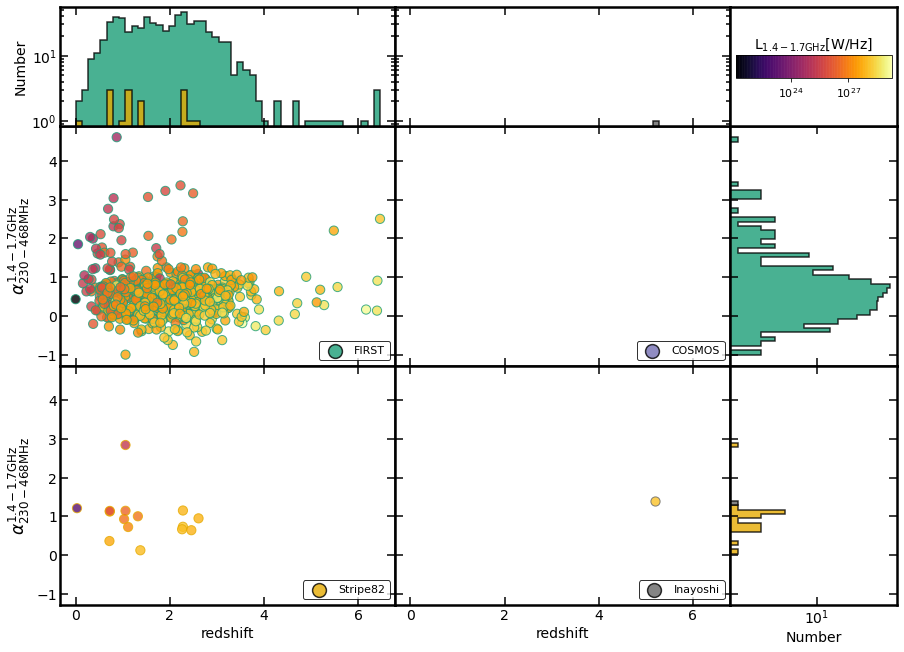

In [30]:
fig             = plt.figure(figsize=(15,11))

plot_spec_index_hist(col_a_spec, col_b_spec, fig)

In [31]:
col_a_spec      = 'Flux 2.2-5.5 GHz'
col_b_spec      = 'Flux 1.4-1.7 GHz'

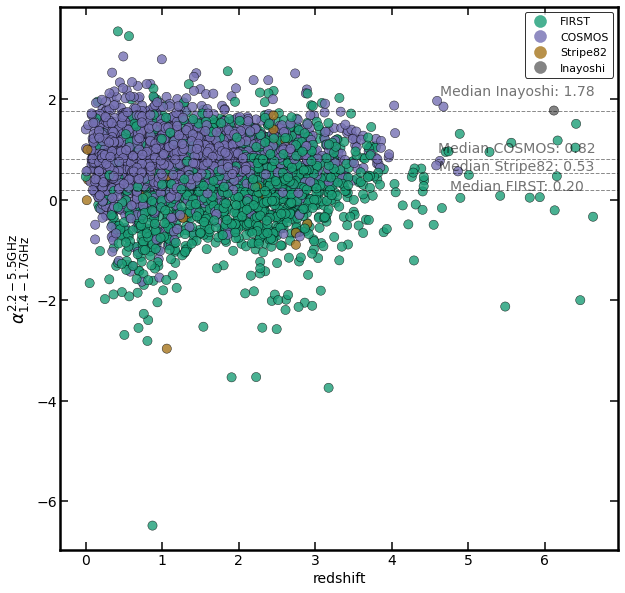

In [32]:
fig             = plt.figure(figsize=(10,10))
ax1             = fig.add_subplot(111)

plot_spec_index(col_a_spec, col_b_spec, ax1)

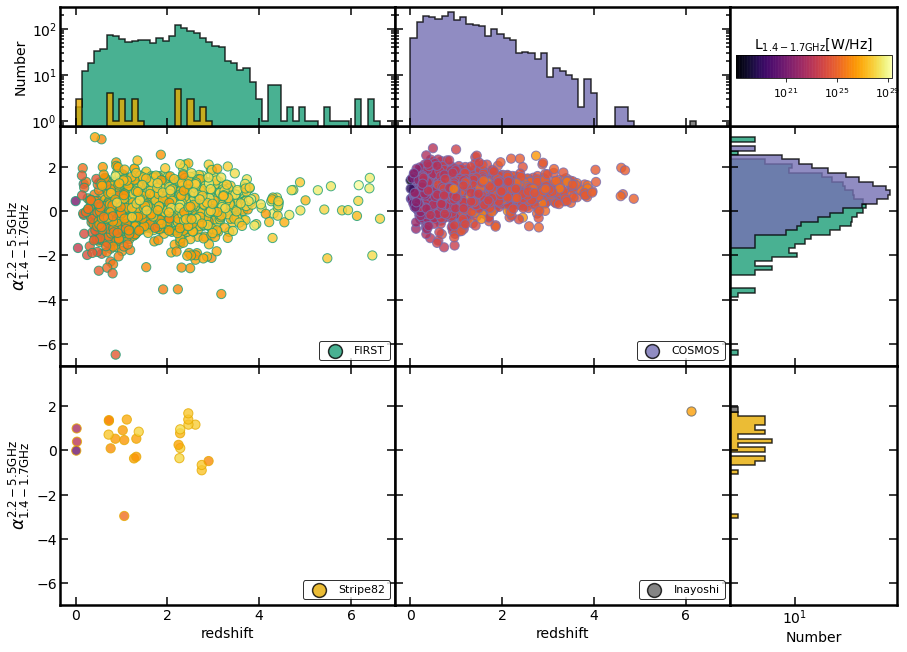

In [33]:
fig             = plt.figure(figsize=(15,11))

plot_spec_index_hist(col_a_spec, col_b_spec, fig)

In [34]:
col_a_spec      = 'Flux 7.7-17 GHz'
col_b_spec      = 'Flux 1.4-1.7 GHz'

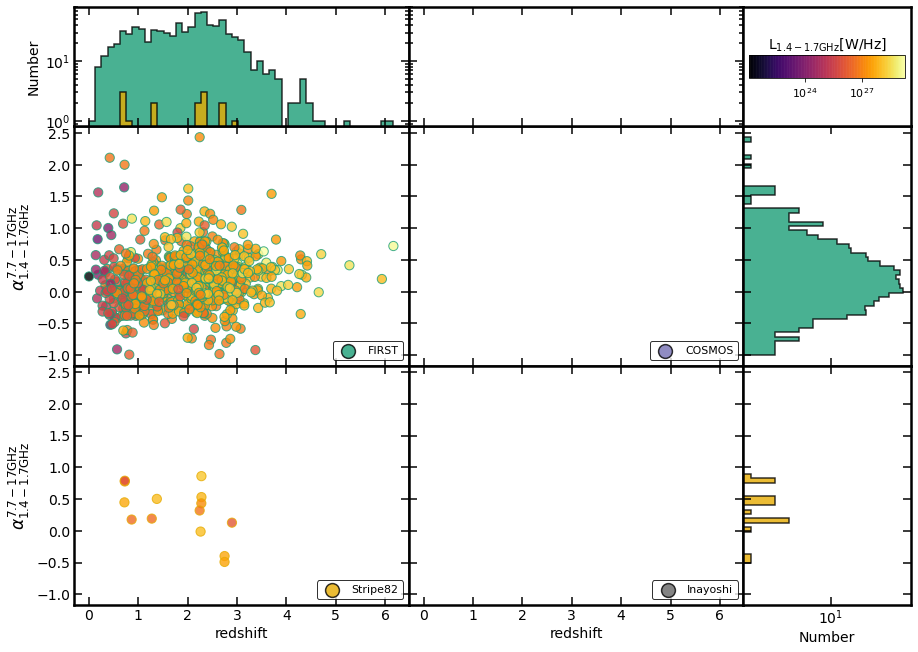

In [35]:
fig             = plt.figure(figsize=(15,11))

plot_spec_index_hist(col_a_spec, col_b_spec, fig)

In [36]:
col_a_spec      = 'Flux 203-375 GHz'
col_b_spec      = 'Flux 1.4-1.7 GHz'

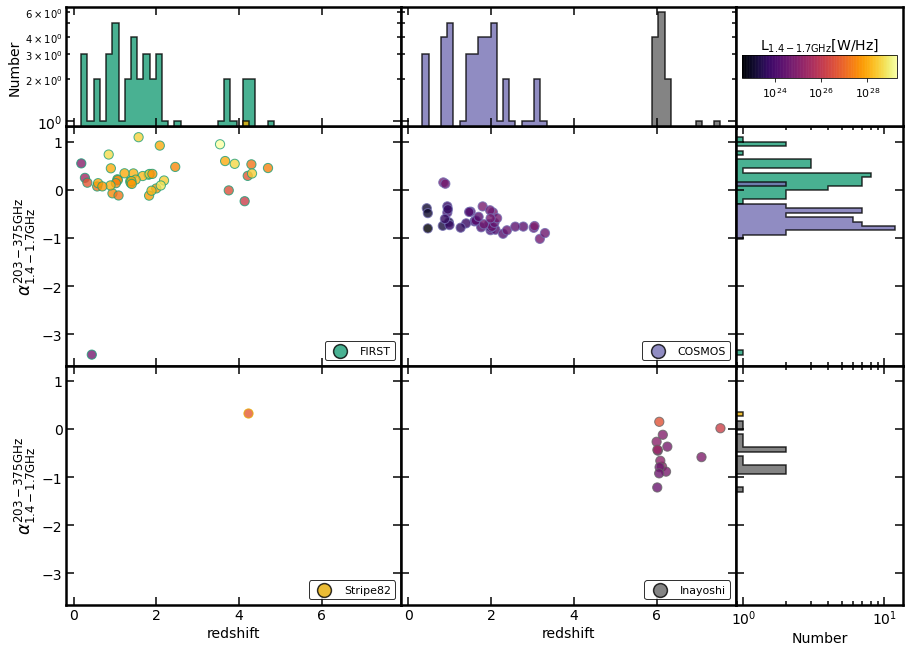

In [37]:
fig             = plt.figure(figsize=(15,11))

plot_spec_index_hist(col_a_spec, col_b_spec, fig)

In [38]:
col_a_spec      = 'Flux 0.1-12 keV'
col_b_spec      = 'Flux 1.4-1.7 GHz'

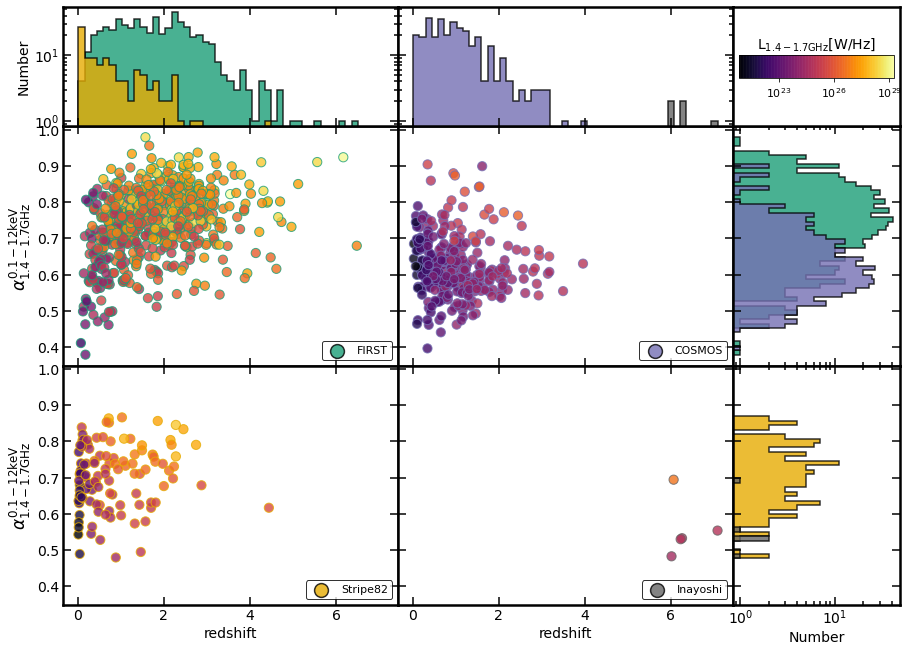

In [39]:
fig             = plt.figure(figsize=(15,11))

plot_spec_index_hist(col_a_spec, col_b_spec, fig)

In [40]:
col_a_spec      = 'Flux 0.1-12 keV'
col_b_spec      = 'Flux 2.2-5.5 GHz'

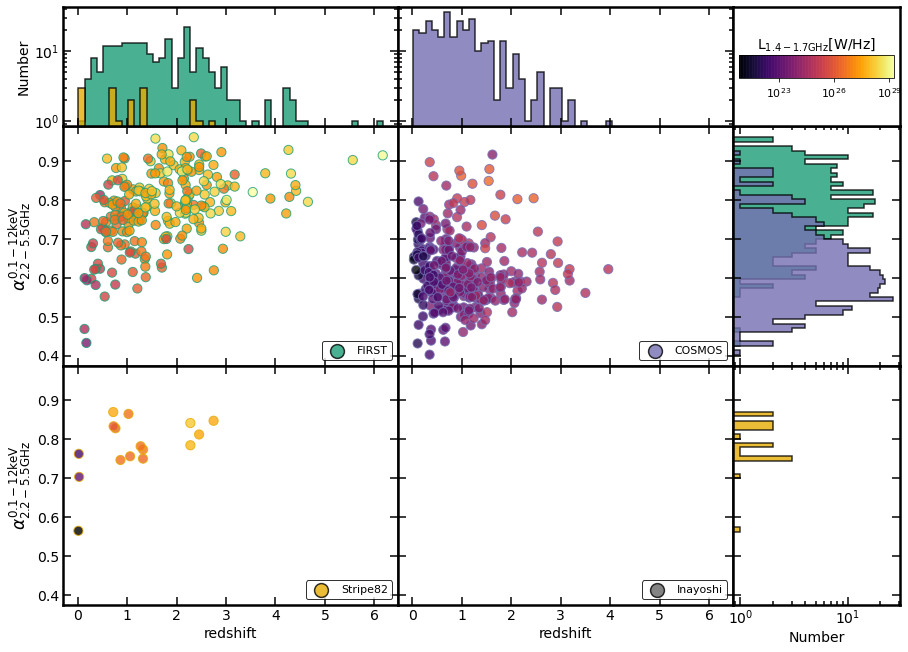

In [41]:
fig             = plt.figure(figsize=(15,11))

plot_spec_index_hist(col_a_spec, col_b_spec, fig)

In [42]:
col_a_spec      = 'Flux 203-375 GHz'
col_b_spec      = 'Flux 2.2-5.5 GHz'

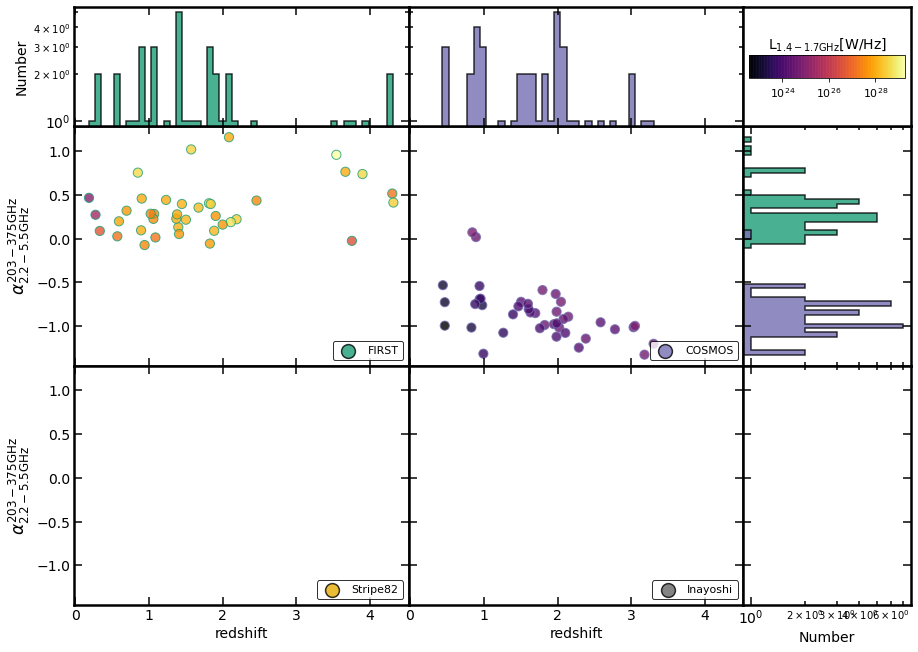

In [43]:
fig             = plt.figure(figsize=(15,11))

plot_spec_index_hist(col_a_spec, col_b_spec, fig)

In [44]:
col_a_spec      = 'Flux NUV'
col_b_spec      = 'Flux 1.4-1.7 GHz'

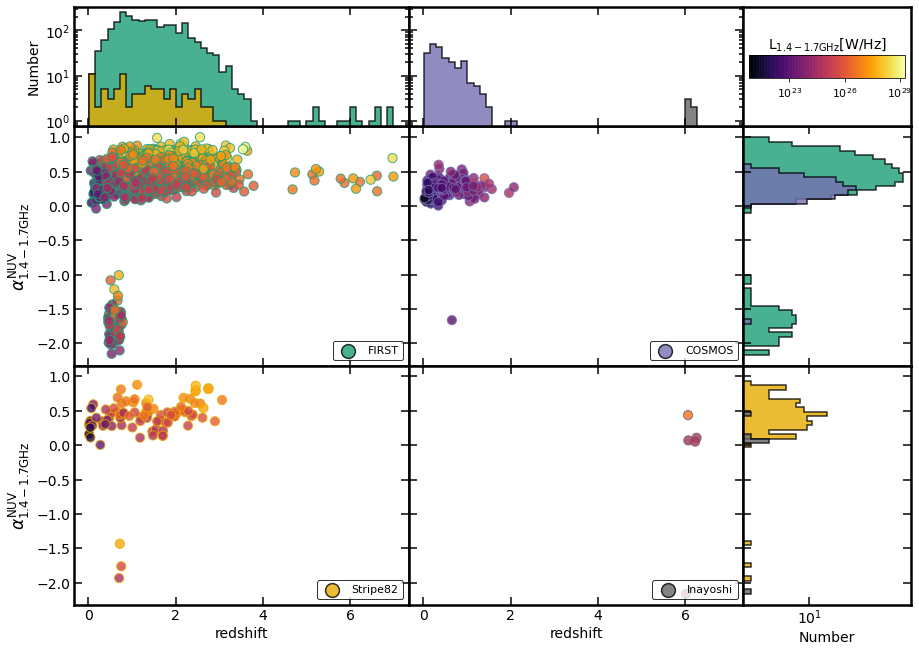

In [45]:
fig             = plt.figure(figsize=(15,11))

plot_spec_index_hist(col_a_spec, col_b_spec, fig)

In [46]:
col_a_spec      = 'Flux FUV'
col_b_spec      = 'Flux 1.4-1.7 GHz'

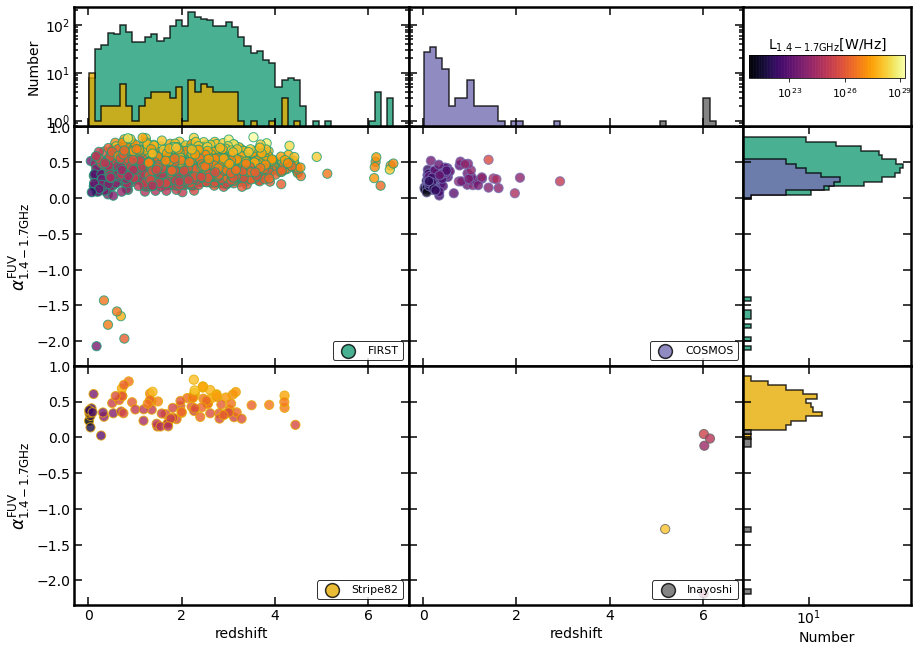

In [47]:
fig             = plt.figure(figsize=(15,11))

plot_spec_index_hist(col_a_spec, col_b_spec, fig)

In [48]:
col_a_spec      = 'Flux NUV'
col_b_spec      = 'Flux 0.1-12 keV'

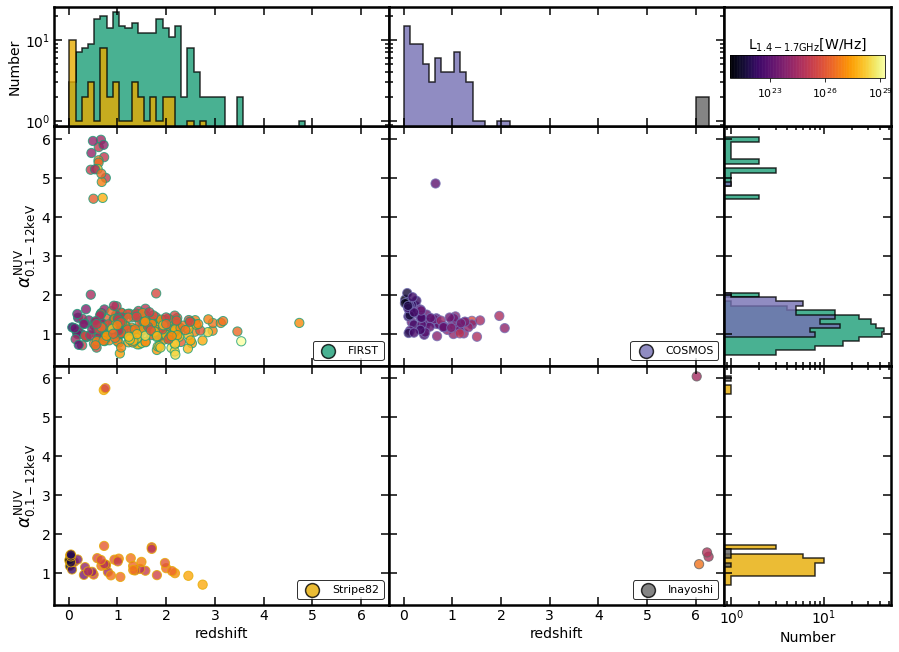

In [49]:
fig             = plt.figure(figsize=(15,11))

plot_spec_index_hist(col_a_spec, col_b_spec, fig)

In [50]:
col_a_spec      = 'Flux 3-8 microns'
col_b_spec      = 'Flux 0.1-12 keV'

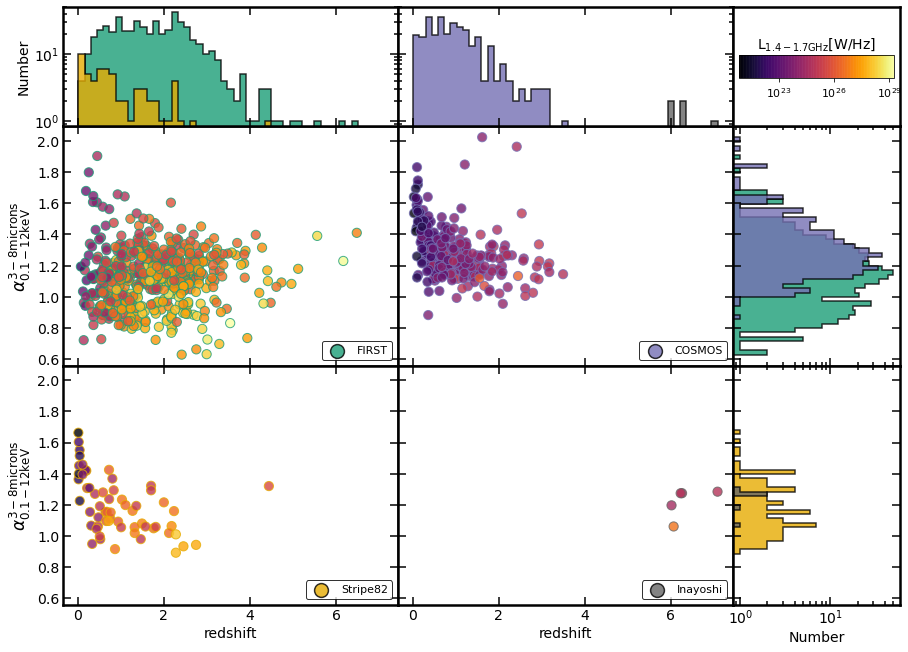

In [51]:
fig             = plt.figure(figsize=(15,11))

plot_spec_index_hist(col_a_spec, col_b_spec, fig)

In [52]:
col_a_spec      = 'Flux u'
col_b_spec      = 'Flux 0.1-12 keV'

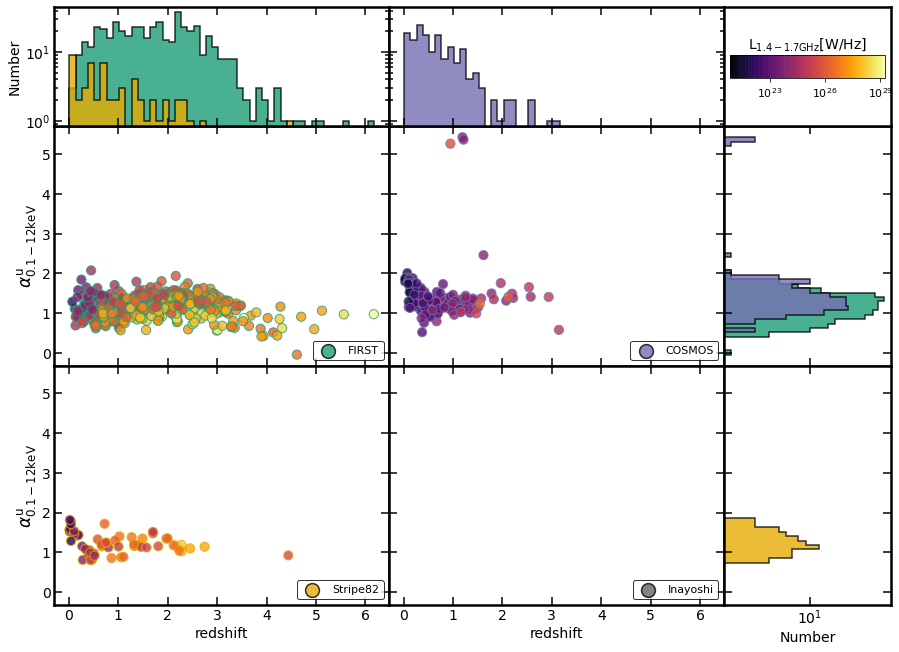

In [53]:
fig             = plt.figure(figsize=(15,11))

plot_spec_index_hist(col_a_spec, col_b_spec, fig)

---